# Bright time survey simulations using Gaia DR1

In [1]:
# Python imports
from importlib import reload
import os
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as c
from astropy.table import Table
import astropy.units as u
import mpl_toolkits.basemap
import matplotlib.pyplot as pl

In [2]:
# Desi-specific imports
import desitarget.mock.io as mock_io
from desitarget import mws_mask
import desiutil.plots as desiplots
import bright_analysis.sweeps.io as sweeps
reload(sweeps);

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Description

This is very simplistic test of running Gaia DR1 through the survey simulation pipeline together with the standard BGS MXXL mock.

To do this I've made some sweeping assumptions:
- Magnitude cuts have the MWS default values, but applied to Gaia's `phot_g_mean_mag` rather than DECam_r.
- There is no '100pc' distance cut.
- I've left out the 100pc and WD samples from the GUMS mocks altogether.
- I've selected 'stars' in Gaia DR1 using the cut on `astrometric_excess_noise` given in sec 2.2. of Koposov, Belokurov & Torrealba 2017 (arxiv/1702.01122). 

## 1. Simulation config

In [4]:
SIM_ROOT    = '/gpfs/data/dph3apc/desi/mysurveys/gaiatest_full'
CONFIG_YAML = os.path.join(SIM_ROOT,'input/mock_bright.yaml')

In [5]:
# Root paths to sweeps
sweep_roots = sweeps.sweep_mock_roots(CONFIG_YAML,'output/sweep')

In [6]:
import yaml
with open(os.path.join(SIM_ROOT,'input/mock_bright.yaml'),'r') as f:
    config = yaml.load(f)

## 2. Load data from sweeps

Sweeps are the subset of the mock that pass through the target selection routines and hence appear in `targets.fits`. These are further split into `observed` (those that get a fiber during the survey) and `unobserved` (those that don't).

Here we look at `MWS_MAIN` only.

In [7]:
# To read the whole mock (not necessary)
# mock = mock_io.read_galaxia(config['sources']['MWS_MAIN']['root_mock_dir'],'MWS_MAIN');

In [8]:
# targets.fits (output of target selection, input to fibre assignment)
targets  = fits.getdata(os.path.join(SIM_ROOT,'input/bright/targets.fits'))

In [9]:
Table(targets[0:3])

TARGETID,RA,DEC,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,BRICKNAME,DECAM_FLUX [6],SHAPEDEV_R,SHAPEEXP_R,DEPTH_R,GALDEPTH_R
int64,float64,float64,int64,int64,int64,float64,float64,str8,float32,float32,float32,float32,float32
3013378040946926990,8.63663768768,-3.19242286682,1152921504606846976,2,0,0.498448338919,4.0,0087m030,0.0 .. 0.0,0.0,0.0,23.7541,23.5242
2137186942441716831,32.2679862976,-1.91859793663,1152921504606846976,1,0,0.377933190289,4.0,0322m020,0.0 .. 0.0,0.0,0.0,24.49,24.3144
3345219275486114972,67.0713500977,-12.0700149536,1152921504606846976,1,0,0.527604289193,4.0,0670m120,0.0 .. 0.0,0.0,0.0,24.2438,23.9639


In [10]:
# Read the sweeps. This uses a function in bright_analysis.
data_obs = sweeps.prepare_sweep_data(os.path.join(SIM_ROOT,sweep_roots['MWS_MAIN']),epoch=2,filetype='observed')

Loading data for epoch 2 under /gpfs/data/dph3apc/desi/mysurveys/gaiatest_full/output/sweep/gpfs/data/DESI/GAIA/DR1/desi/output/bricks
Read 7718398 rows from 200 files in 34.404120s


In [11]:
Table(data_obs[0:3])

RA,DEC,RA_ERROR,DEC_ERROR,ASTROMETRIC_WEIGHT_AL,PHOT_G_MEAN_MAG,PHOT_G_MEAN_FLUX_ERROR,PHOT_G_N_OBS,ASTROMETRIC_N_OBS_AL,ASTROMETRIC_EXCESS_NOISE,SDSSg_obs,SDSSr_obs,SDSSi_obs,SDSSz_obs,SDSSr_true,d_helio,v_helio,objid,brickname,brickid,TARGETROW,TARGETID,IN_FOOTPRINT
float64,float64,float32,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes8,int64,int32,int64,int8
8.5097856436,-14.5872507544,0.659086,0.305309,1.65311,16.9662,5.61212,110,111,0.433242,16.9662,15.9662,15.5662,15.3662,15.9662,10.0,0.0,2373955383732562944,0050m100,175,20842446,2108084992229912243,84
8.48044667678,-14.5534334736,2.44472,1.39532,0.171699,18.9645,3.06561,94,96,1.07552,18.9645,17.9645,17.5645,17.3645,17.9645,10.0,0.0,2373958716627187200,0050m100,175,20842472,2930275786823949920,84
9.83389507312,-14.708602165,1.92146,0.855552,0.165253,18.2712,3.93835,141,142,1.90634,18.2712,17.2712,16.8712,16.6712,17.2712,10.0,0.0,2374093166283549312,0050m100,175,20842592,4514885533486823777,84


In [12]:
data_unobs = sweeps.prepare_sweep_data(os.path.join(SIM_ROOT,sweep_roots['MWS_MAIN']),epoch=2,filetype='unobserved')

Loading data for epoch 2 under /gpfs/data/dph3apc/desi/mysurveys/gaiatest_full/output/sweep/gpfs/data/DESI/GAIA/DR1/desi/output/bricks
Read 40721840 rows from 200 files in 96.581150s


## 3. Summary of MWS_MAIN

In [13]:
nselected = len(data_obs)+len(data_unobs)
print('{:d} selected, {:d} observed'.format(nselected,len(data_obs)))
print('{:f}% of selected targets observed'.format(100.0*float(len(data_obs))/float(nselected)))

48440238 selected, 7718398 observed
15.933856% of selected targets observed


In [14]:
def summary_observed(targets,targetrows_obs,targetrows_unobs,target_class,mask):
    """
    """
    target_bit_name = target_class.split('_')[0] + '_TARGET'
    
    targetbit_o  = targets[target_bit_name][targetrows_obs]
    targetbit_u  = targets[target_bit_name][targetrows_unobs]
    
    in_class_o   = targetbit_o & mask.mask(target_class) != 0
    in_class_u   = targetbit_u & mask.mask(target_class) != 0

    n_o =  float(in_class_o.sum())
    n_u =  float(in_class_u.sum())
    n_t = n_o + n_u
    
    print('Of {ntot:d} stars that were selected as {target_class}, {nobs:d} were observed ({frac:5f})'.format(
            target_class=target_class,nobs=int(n_o),ntot=int(n_u),frac=n_o/n_t))
    
    return in_class_o, in_class_u


In [15]:
main_obs, main_unobs = summary_observed(targets,data_obs['TARGETROW'],data_unobs['TARGETROW'],
                                        'MWS_MAIN',mws_mask)

Of 24463315 stars that were selected as MWS_MAIN, 7209460 were observed (0.227623)


In [16]:
faint_obs, faint_unobs = summary_observed(targets,data_obs['TARGETROW'],data_unobs['TARGETROW'],
                                          'MWS_MAIN_VERY_FAINT',mws_mask)

Of 16258525 stars that were selected as MWS_MAIN_VERY_FAINT, 508938 were observed (0.030353)


In [18]:
data_obs.dtype.names

('RA',
 'DEC',
 'RA_ERROR',
 'DEC_ERROR',
 'ASTROMETRIC_WEIGHT_AL',
 'PHOT_G_MEAN_MAG',
 'PHOT_G_MEAN_FLUX_ERROR',
 'PHOT_G_N_OBS',
 'ASTROMETRIC_N_OBS_AL',
 'ASTROMETRIC_EXCESS_NOISE',
 'SDSSg_obs',
 'SDSSr_obs',
 'SDSSi_obs',
 'SDSSz_obs',
 'SDSSr_true',
 'd_helio',
 'v_helio',
 'objid',
 'brickname',
 'brickid',
 'TARGETROW',
 'TARGETID',
 'IN_FOOTPRINT')

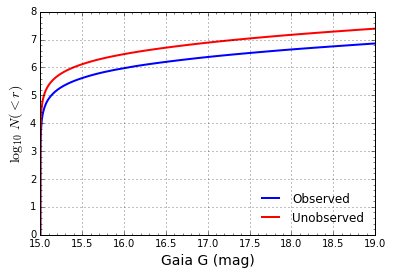

In [19]:
# Observed
d = data_obs['PHOT_G_MEAN_MAG'][main_obs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a],np.log10(y),lw=2,c='b',label='Observed')

# Unobserved
d = data_unobs['PHOT_G_MEAN_MAG'][main_unobs]
a = np.argsort(d)
y = np.arange(1,1+len(d))
plot(d[a],np.log10(y),lw=2,c='r',label='Unobserved')

pl.xlabel('Gaia G (mag)',fontsize=14)
pl.ylabel('$\log_{10}\ N(<r)$',fontsize=14)
pl.legend(loc='lower right',frameon=False)
pl.minorticks_on()
pl.grid();

## 4. Coordinates

In [22]:
# Objects for coordinate conversions, MWS_MAIN only
c_obs   = c.SkyCoord(data_obs[main_obs]['RA'],data_obs[main_obs]['DEC'],unit='deg',frame='icrs')
c_unobs = c.SkyCoord(data_unobs[main_unobs]['RA'],data_unobs[main_unobs]['DEC'],unit='deg',frame='icrs')

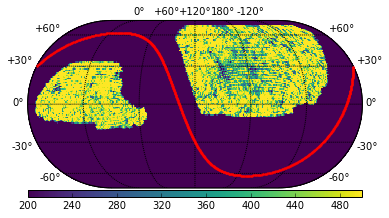

In [23]:
desiplots.plot_sky_binned(c_obs.ra,c_obs.dec,max_bin_area=1,clip_lo=200,clip_hi=500);

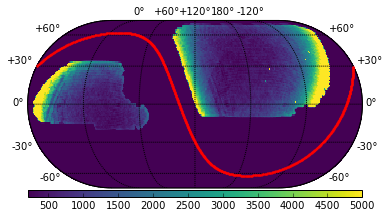

In [24]:
desiplots.plot_sky_binned(c_unobs.ra,c_unobs.dec,max_bin_area=1,clip_lo=200,clip_hi=5000);

In [32]:
# Healpix binning
import healpy as hp
NSIDE = 2**6 # 64, about 0.8 sq. deg.

def ra_dec_ang2pix(nside,ra,dec,nest=True):
    """
    Converts (ra, dec) in degrees to Healpix pixels, using ang2pix, assuming
    nest and taking into account differences in coordinate conventions.
    """
    theta = np.deg2rad(90.0-dec)
    phi   = np.deg2rad(ra)
    return hp.ang2pix(nside,theta,phi,nest=nest)

def ra_dec_pix2ang(nside,ipix,nest=True):
    """
    Converts Healpix ipix to (ra, dec) in degrees, using pix2ang, assuming
    nest and taking into account differences in coordinate conventions.
    """
    theta, phi = hp.pix2ang(nside,ipix,nest=nest)
    dec = -np.rad2deg(theta) + 90.0
    ra  = np.rad2deg(phi)
    return ra, dec

def pix_counts(nside,ra,dec):
    """Count in each pixel"""
    all_ipix           = ra_dec_ang2pix(nside,ra,dec)
    ipix,ipix_count    = np.unique(all_ipix,return_counts=True)
    allpix_count       = np.zeros(hp.nside2npix(nside),dtype=np.float32)
    allpix_count[ipix] = ipix_count
    return allpix_count
    

## 5. Completeness 

#### Counts of observed and unobserved targets in healpix pixels.

In [26]:
ipix_count_obs   = pix_counts(NSIDE,c_obs.ra.value,c_obs.dec.value)
ipix_count_unobs = pix_counts(NSIDE,c_unobs.ra.value,c_unobs.dec.value)

In [27]:
ipix_count_total = ipix_count_obs + ipix_count_unobs
ipix_count_ratio = ipix_count_obs/ipix_count_total

/gpfs/data/dph3apc/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [28]:
# Pixel coordinates, Galactic
ra_ipix, dec_ipix = ra_dec_pix2ang(NSIDE,np.arange(0,hp.nside2npix(NSIDE)))
c_pix = c.SkyCoord(ra_ipix,dec_ipix,unit='deg',frame='icrs')
l_pix = c_pix.galactic.l
b_pix = c_pix.galactic.b

#### Completeness across sky.

Highlighting (in red) pixels around the edge of the footprint where completeness is artificially low.

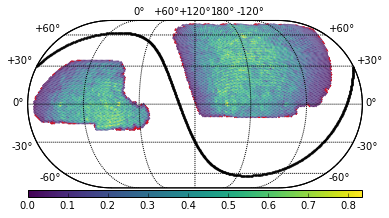

In [29]:
basemap = desiplots.init_sky(galactic_plane_color='k')
desiplots.plot_healpix_map(ipix_count_ratio,nest=True,basemap=basemap)
z = np.where((ipix_count_total > 0) & (ipix_count_ratio == 0))[0]
desiplots.plot_sky_circles(ra_ipix[z],dec_ipix[z],basemap=basemap,field_of_view=1,facecolors='r',edgecolor='None');

#### Fraction of survey area above a given completeness.

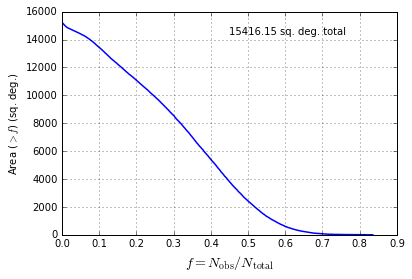

In [30]:
x = ipix_count_ratio[ipix_count_total > 10]
total_area = hp.nside2pixarea(NSIDE,degrees=True)*len(x)

a = np.argsort(x)
y = np.arange(1,len(x)+1)/float(len(x))
pl.plot(x[a[::-1]],y*total_area,lw=1.5)

ax = pl.gca()
pl.text(0.5,0.9,'{:6.2f} sq. deg. total'.format(total_area),transform=ax.transAxes)
pl.grid()
pl.xlabel('$f = N_{\mathrm{obs}}/N_{\mathrm{total}}$',fontsize=14)
pl.ylabel('Area ($>f$) (sq. deg.)');

#### Completeness in Healpix pixels.

Scatter plot of completeness in each pixel vs. the Galactic latitude of that pixel.

Restriction to having > 10 stars available to limit contribution of pixels at the edge of the footprint.

/gpfs/data/dph3apc/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Total area of (partly) observed HP pixels: 15213.875907 sq. deg.


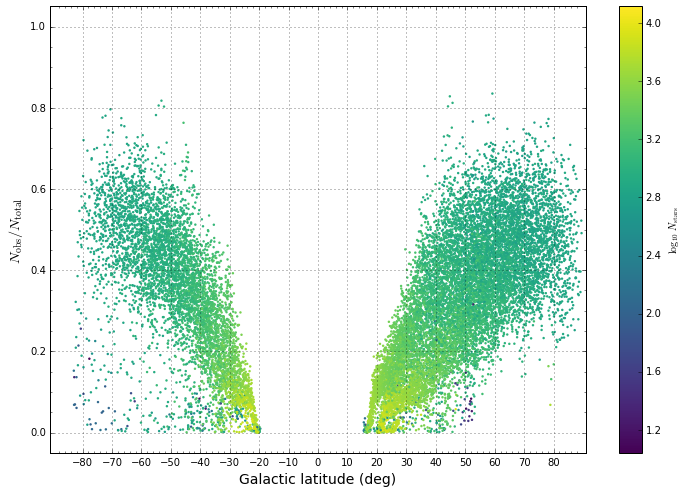

In [31]:
pl.figure(figsize=(12,8))

s = (ipix_count_total > 10) & (ipix_count_ratio > 0)
print('Total area of (partly) observed HP pixels: {:f} sq. deg.'.format(s.sum()*hp.nside2pixarea(NSIDE,degrees=True)))
pl.scatter(b_pix[s],ipix_count_ratio[s],
           c=np.log10(ipix_count_total[s]),
           cmap='viridis',
           s=6,
           edgecolor='None')
cbar = pl.colorbar(label='$\log_{10}\ N_{\mathrm{stars}}$')
pl.ylim(-0.05,1.05)
pl.xlim(-91,91)
pl.ylabel('$N_{\mathrm{obs}}/N_{\mathrm{total}}$',fontsize=14)
pl.xlabel('Galactic latitude (deg)',fontsize=14)

ax = pl.gca()
pl.xticks(np.arange(-80,90,10))
pl.minorticks_on()
pl.grid()

In [33]:
print('Total stars available: {:d}'.format(int(np.sum(ipix_count_total[s]))))
print('Total stars observed:  {:d}'.format(int(np.sum(ipix_count_obs[s]))))

print('Ratio: {:f}'.format(np.sum(ipix_count_obs[s])/np.sum(ipix_count_total[s])))

Total stars available: 31429956
Total stars observed:  7209458
Ratio: 0.229382


In [34]:
pixarea = hp.nside2pixarea(NSIDE,degrees=True)

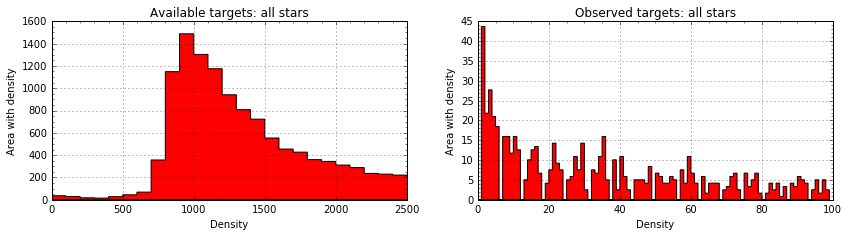

In [35]:
pl.figure(figsize=(14,8))
bins_all = np.arange(0,13000,100.0)
bins = np.arange(0,100,1.0)

ax = pl.subplot(221)
pl.hist(ipix_count_total[s]/pixarea,bins=bins_all,
        weights=np.ones_like(ipix_count_total[s])*pixarea,
        histtype='stepfilled',color='r');
pl.xlabel('Density')
pl.xlim(0,2500)
pl.ylabel('Area with density')
pl.title('Available targets: all stars')
pl.minorticks_on()
pl.grid()

ax = pl.subplot(222)
pl.hist(ipix_count_obs[s]/pixarea,bins=bins,
        weights=np.ones_like(ipix_count_total[s])*pixarea,
        histtype='stepfilled',color='r');
pl.xlabel('Density')
pl.xlim(0,100)
pl.ylabel('Area with density')
pl.title('Observed targets: all stars')
pl.minorticks_on()
pl.grid()

pl.subplots_adjust(hspace=0.5)

#### Observed vs. Target density in Healpix pixels

/gpfs/data/dph3apc/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Total area of (partly) observed HP pixels: 15213.875907 sq. deg.


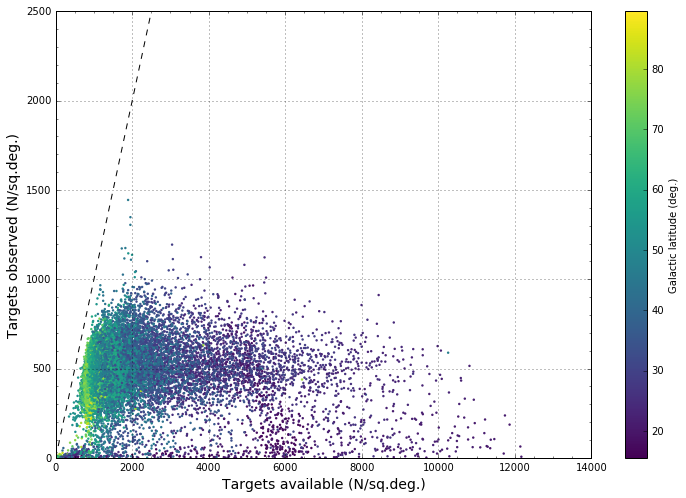

In [36]:
pl.figure(figsize=(12,8))
pixarea = hp.nside2pixarea(NSIDE,degrees=True)
s = (ipix_count_total > 10) & (ipix_count_ratio > 0)
print('Total area of (partly) observed HP pixels: {:f} sq. deg.'.format(s.sum()*pixarea))
pl.scatter(ipix_count_total[s]/pixarea,ipix_count_obs[s]/pixarea,
           c=np.abs(b_pix[s]),
           cmap='viridis',
           s=6,
           edgecolor='None')
cbar = pl.colorbar(label='Galactic latitude (deg.)')
pl.ylim(-0.05,2500)
pl.ylabel('Targets observed (N/sq.deg.)',fontsize=14)
pl.xlabel('Targets available (N/sq.deg.)',fontsize=14)

ax = pl.gca()
pl.minorticks_on()
pl.grid()
pl.xlim(0,14000)
pl.ylim(0,2500)
pl.plot([0,2500],[0,2500],c='k',ls='--');

#### Total average surface density to a given faint limit, in Gaia mags

In [52]:
gaia_Gmag_obs = data_obs[main_obs | faint_obs]['PHOT_G_MEAN_MAG']

In [53]:
gaia_Gmag_unobs = data_unobs[main_unobs | faint_unobs]['PHOT_G_MEAN_MAG']

In [54]:
gaia_Gmag_all = np.concatenate([gaia_Gmag_obs,gaia_Gmag_unobs])

In [47]:
_c_obs   = c.SkyCoord(data_obs['RA'],data_obs['DEC'],unit='deg',frame='icrs')
_c_unobs = c.SkyCoord(data_unobs['RA'],data_unobs['DEC'],unit='deg',frame='icrs')
c_all    = c.concatenate([_c_obs,_c_unobs])

In [48]:
limits = [18.0,18.5,19.0,19.5,19.75,20.0]

In [49]:
highpix = np.abs(b_pix.value) > 30.0

In [55]:
sd_at_limit         = list()
sd_at_limit_h         = list()

for l in limits:
    print('Limit: %f'%(l))
    s       = gaia_Gmag_all < l
    ipix_count         = pix_counts(NSIDE,c_all[s].ra.value,c_all[s].dec.value)
    
    z = (ipix_count > 10)
    sd_at_limit.append(np.sum(ipix_count[z])/(z.sum()*hp.nside2pixarea(NSIDE,degrees=True)))
  
    z = (ipix_count > 10) & highpix
    sd_at_limit_h.append(np.sum(ipix_count[z])/(z.sum()*hp.nside2pixarea(NSIDE,degrees=True)))

Limit: 18.000000
Limit: 18.500000
Limit: 19.000000
Limit: 19.500000
Limit: 19.750000
Limit: 20.000000


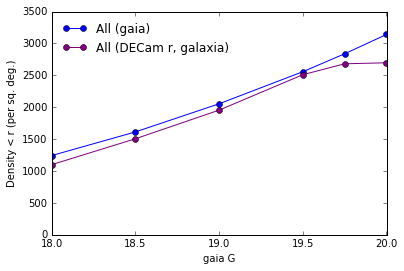

In [63]:
plot(limits,sd_at_limit,marker='o',c='b',label='All (gaia)')

input_data = Table.read('./density_vs_decam_r.02may2017_full.txt',format='ascii')
plot(input_data['decam_r'],input_data['density'],marker='o',c='purple',label='All (DECam r, galaxia)')

pl.ylim(0,3500)
pl.xlabel('gaia G')
pl.ylabel('Density < r (per sq. deg.)')
pl.legend(frameon=False,loc='upper left');

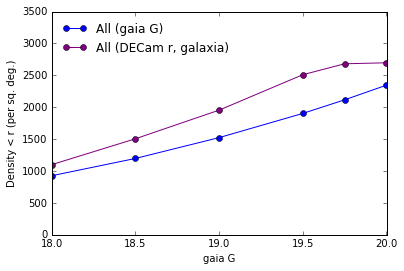

In [65]:
# Healpixels with b > 30
plot(limits,sd_at_limit_h,marker='o',c='b',label='All (gaia G)')

input_data = Table.read('./density_vs_decam_r.highlat.02may2017_full.txt',format='ascii')
plot(input_data['decam_r'],input_data['density'],marker='o',c='purple',label='All (DECam r, galaxia)')

pl.ylim(0,3500)
pl.xlabel('gaia G')
pl.ylabel('Density < r (per sq. deg.)')
pl.legend(frameon=False,loc='upper left');

In [78]:
xx = np.where(c_unobs.separation(c.SkyCoord(260.051666*u.deg,57.915277*u.deg)) < 2*u.deg)[0]

In [90]:
len(xx)

25972

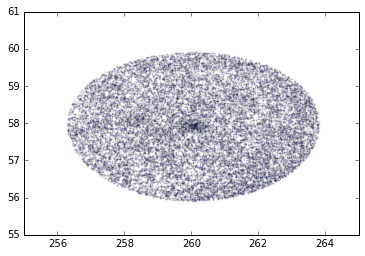

In [83]:
pl.scatter(c_unobs.ra[xx],c_unobs.dec[xx],s=1,alpha=0.1)

In [91]:
yy = np.where(c_unobs.separation(c.SkyCoord(260.051666*u.deg,57.915277*u.deg)) < 1*u.arcmin)[0]

In [88]:
len(yy)

0

(57, 59)

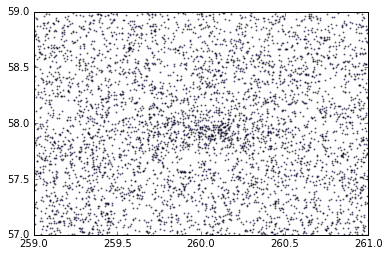

In [87]:
pl.scatter(c_unobs.ra[xx],c_unobs.dec[xx],s=1,alpha=0.5)
pl.scatter(c_unobs.ra[yy],c_unobs.dec[yy],s=3,alpha=1.0,c='r')
pl.xlim(259,261)
pl.ylim(57,59)